In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from redist import modifier
from redist import plot
from knunu_utils import * 

# Reinterpreting $B \to K \nu \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of one kinematic variable: $q^2$.

We use $q^2$ also as the fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [2]:
binning = np.linspace(0.0, 22.9, 13) 
bin_cents = (binning[:-1] + binning[1:])/2
q2binning = np.linspace(0.0, 22.9, 24)

## Generate some SM samples

In [3]:
SMsamples = 50000

p = analysis().parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=22.90)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

pdf = eos.SignalPDF.make('B^-->K^-nunu::dGamma/dq2', p, k, o)
obs = eos.Observable.make('B->Knunu::BR', p, k, o)
SMBR = obs.evaluate()

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [4]:
null_samples_smeared = np.random.normal(null_samples, 1.0, null_samples.shape)
null_samples_smeared = np.abs(null_samples_smeared)

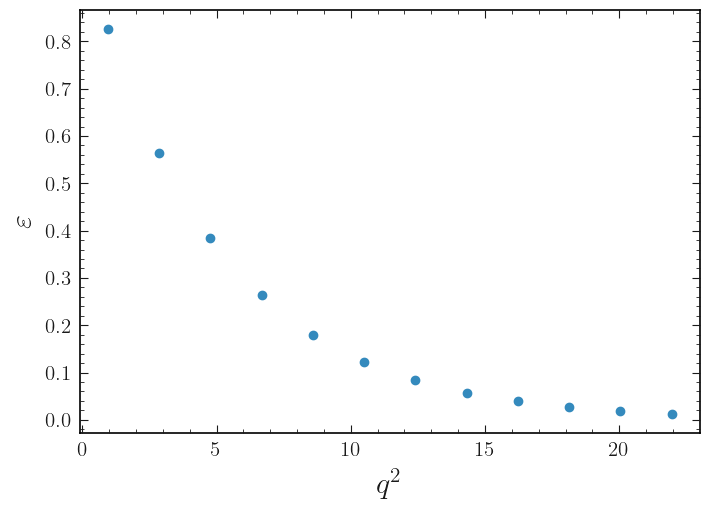

In [5]:
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

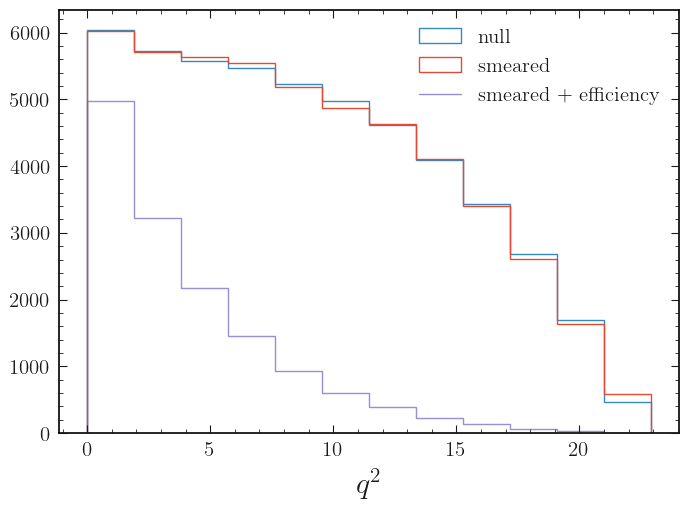

In [6]:
plt.hist(null_samples, binning, histtype='step', label='null')
null_yields, _, _ = plt.hist(null_samples_smeared, binning, histtype='step', label='smeared')
null_yields *= efficiency(bin_cents)
plt.stairs(null_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$')
plt.legend()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [7]:
p['sbnunu::Re{cVL}'].set(5.0)
p['sbnunu::Re{cVR}'].set(0.5)
p['sbnunu::Re{cSL}'].set(0.5)
p['sbnunu::Re{cSR}'].set(0.5)
p['sbnunu::Re{cTL}'].set(0.5)

BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [8]:
alt_samples_smeared = np.random.normal(alt_samples, 1.0, alt_samples.shape)
alt_samples_smeared = np.abs(alt_samples_smeared)

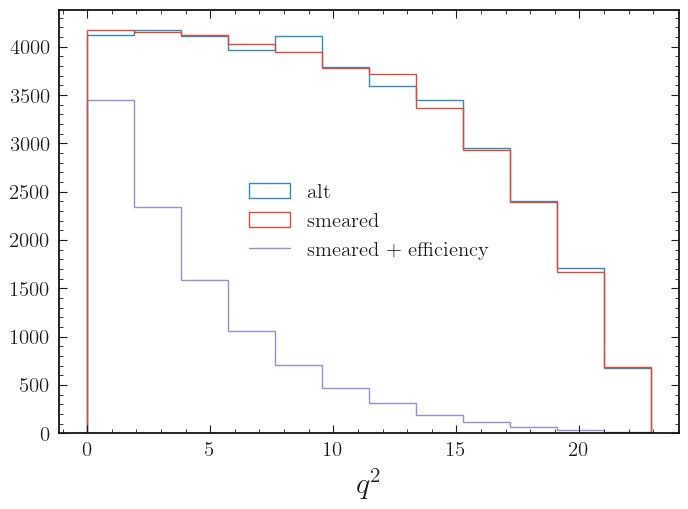

In [9]:
plt.hist(alt_samples, binning, histtype='step', label='alt')
alt_yields, _, _ = plt.hist(alt_samples_smeared, binning, histtype='step', label='smeared')
alt_yields *= efficiency(bin_cents)
plt.stairs(alt_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$')
plt.legend()

## Set up the mapping distribution

In [10]:
mapping_dist = np.histogramdd([null_samples.flatten(), null_samples_smeared.flatten()], bins=[binning, q2binning])[0]
mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

## Set up the custom modifier

In [11]:
null = null_pred()
alt = alt_pred()

In [12]:
ana = analysis()
cvl  = ana.parameters['sbnunu::Re{cVL}'        ].evaluate()
cvr  = ana.parameters['sbnunu::Re{cVR}'        ].evaluate()
csl  = ana.parameters['sbnunu::Re{cSL}'        ].evaluate()
csr  = ana.parameters['sbnunu::Re{cSR}'        ].evaluate()
ctl  = ana.parameters['sbnunu::Re{cTL}'        ].evaluate()
fp0 = ana.parameters['B->K::alpha^f+_0@BSZ2015'].evaluate()
fp1 = ana.parameters['B->K::alpha^f+_1@BSZ2015'].evaluate()
fp2 = ana.parameters['B->K::alpha^f+_2@BSZ2015'].evaluate()
f01 = ana.parameters['B->K::alpha^f0_1@BSZ2015'].evaluate()
f02 = ana.parameters['B->K::alpha^f0_2@BSZ2015'].evaluate()
fT0 = ana.parameters['B->K::alpha^fT_0@BSZ2015'].evaluate()
fT1 = ana.parameters['B->K::alpha^fT_1@BSZ2015'].evaluate()
fT2 = ana.parameters['B->K::alpha^fT_2@BSZ2015'].evaluate()

In [13]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7
0,0.000109,0.000696,0.000979,0.000775,0.001303,0.000088,0.000565,0.000760
1,0.000696,0.009307,0.021609,0.005688,0.010247,0.000392,0.006202,0.014710
2,0.000979,0.021609,0.067185,0.008526,0.017058,0.000097,0.011229,0.042544
3,0.000775,0.005688,0.008526,0.006233,0.011288,0.000612,0.004714,0.006588
4,0.001303,0.010247,0.017058,0.011288,0.022037,0.000978,0.008112,0.012782
5,0.000088,0.000392,0.000097,0.000612,0.000978,0.000473,0.003446,0.005830
6,0.000565,0.006202,0.011229,0.004714,0.008112,0.003446,0.031871,0.061918
7,0.000760,0.014710,0.042544,0.006588,0.012782,0.005830,0.061918,0.144128


In [14]:
new_params = {
                'cvl'   :{'inits': (6.0,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'cvr'   :{'inits': (0.0,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.0,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'csr'   :{'inits': (0.0,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.0,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'FFK'   :{'inits': (fp0, fp1, fp2, f01, f02, fT0, fT1, fT2), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()], name='knunu')

(<Figure size 700x500 with 1 Axes>,
 <Axes: xlabel='$q^2$ [GeV$^2$]', ylabel='$d\\mathcal{B}/dq^2$'>)

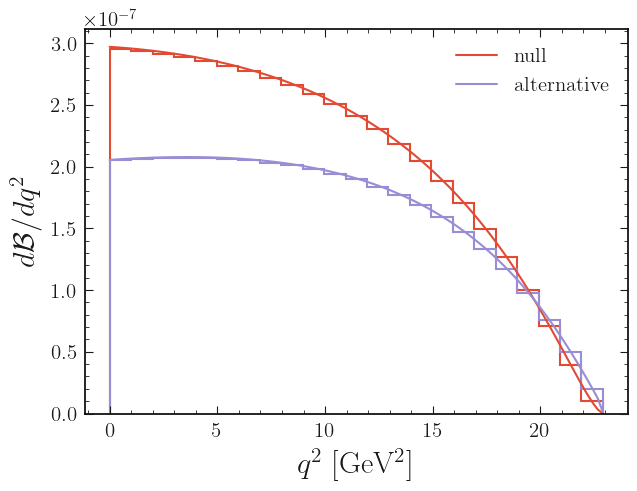

In [15]:
cvl = 5.0
cvr = 0.5
csl = 0.5
csr = 0.5
ctl = 0.5

pars = (cvl, cvr, csl, csr, ctl, fp0, fp1, fp2, f01, f02, fT0, fT1, fT2)
lims = [0.0, 22.9]
labels = [r'$q^2$ [GeV$^2$]', r'$d\mathcal{B}/dq^2$']
plot.dists(cmod, pars, lims, labels)

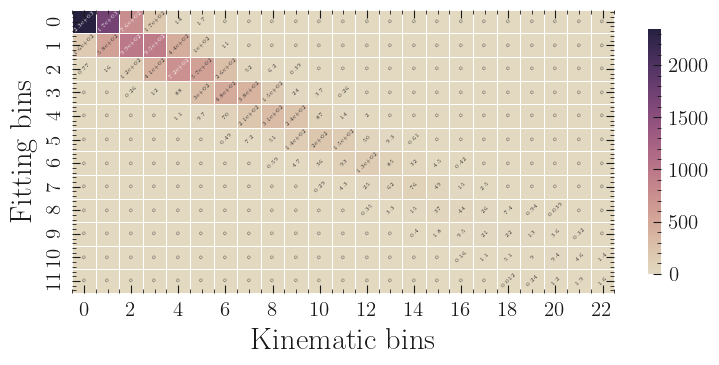

In [16]:
plot.map(cmod)

## Set up the model

In [17]:
spec = {
  "channels": [
    {
      "name": "B->Knunu",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "knunu_theory",
                "type": "knunu",
                "data":{"expr": "knunu_weight_fn"}
              }

model = modifier.add_to_model(model, ['B->Knunu'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'B->Knunu',
   'samples': [{'name': 'signal',
     'data': [4978.278487553286,
      3219.95923524568,
      2167.143137743119,
      1456.9448234914403,
      931.6795975805924,
      597.350215795864,
      387.6591802105221,
      234.15851967342394,
      132.52557366106154,
      69.54946020323028,
      29.795029334529353,
      7.198419131709988],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [70.55691665282211,
        56.74468464310714,
        46.552584651586415,
        38.16994660058408,
        30.523427028769106,
        24.44074908418038,
        19.689062451283,
        15.302239041180345,
        11.511975228476716,
        8.33963189854506,
        5.458482328864806,
        2.6829869794149186]},
      {'name': 'knunu_theory',
       'type': 'knunu',
       'data': {'expr': 'knunu_weight_fn'}}]}]}]}

## Save and load model

In [18]:
modifier.save('knunu_model.json', model.spec, cmod, alt_yields)
model, alt_yields = modifier.load('knunu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [19]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']] = [True]
# fixed[model.config.par_map['cvr']['slice']] = [True]
# fixed[model.config.par_map['csr']['slice']] = [True]

# pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
# best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


W MnPosDef Matrix forced pos-def by adding to diagonal 0.419793
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.883114 > 0
W MnPosDef Matrix forced pos-def by adding to diagonal 0.00263445
W VariableMetricBuilder gdel = -23.966
W MnPosDef Matrix forced pos-def by adding to diagonal 0.00878441
W MnPosDef Matrix forced pos-def by adding to diagonal 0.00792119


{'cvl': array([5.49772956, 0.20185454]),
 'cvr': array([2.58370730e-06, 4.28764265e+00]),
 'csl': array([0.42610549, 0.90455727]),
 'csr': array([0.42610549, 0.90455727]),
 'ctl': array([0.64242534, 0.43294874]),
 'FFK_decorrelated[0]': array([0.00282127, 0.97177203]),
 'FFK_decorrelated[1]': array([0.0051773 , 0.95646657]),
 'FFK_decorrelated[2]': array([-4.00887220e-04,  9.05330848e-01]),
 'FFK_decorrelated[3]': array([4.24756188e-04, 9.88438907e-01]),
 'FFK_decorrelated[4]': array([1.43879324e-04, 9.79512828e-01]),
 'FFK_decorrelated[5]': array([0.00431896, 0.96253377]),
 'FFK_decorrelated[6]': array([-9.28848938e-04,  9.88793973e-01]),
 'FFK_decorrelated[7]': array([-0.00098551,  0.98351581]),
 'mu': array([1., 0.]),
 'stat': [[0.9961229843452205, 0.012970155651341297],
  [1.0089137786998068, 0.014579108632963744],
  [1.001698231142394, 0.01720732481420756],
  [0.9888600499908802, 0.020953889280156013],
  [1.0011177224248553, 0.026242386075178814],
  [1.0003930806608163, 0.03263564

In [20]:
best_fit_rot = cmod.rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})
best_fit_rot

{'cvl': 5.497729555521592,
 'cvr': 2.583707298316635e-06,
 'csl': 0.4261054850247533,
 'csr': 0.4261054850247533,
 'ctl': 0.6424253382276754,
 'FFK[0]': 0.3379231348762659,
 'FFK[1]': -0.885062169154491,
 'FFK[2]': -0.11232054750674378,
 'FFK[3]': 0.3738517555045454,
 'FFK[4]': 0.07817243063473732,
 'FFK[5]': 0.3268607045856528,
 'FFK[6]': -0.9626476142110877,
 'FFK[7]': -0.2786302631257813,
 'mu': 1.0,
 'stat': [0.9961229843452205,
  1.0089137786998068,
  1.001698231142394,
  0.9888600499908802,
  1.0011177224248553,
  1.0003930806608163,
  1.0016554804806326,
  0.9980832577105633,
  1.0039920455888331,
  1.0063401808763879,
  0.9951564171883028,
  0.9897742795385965]}

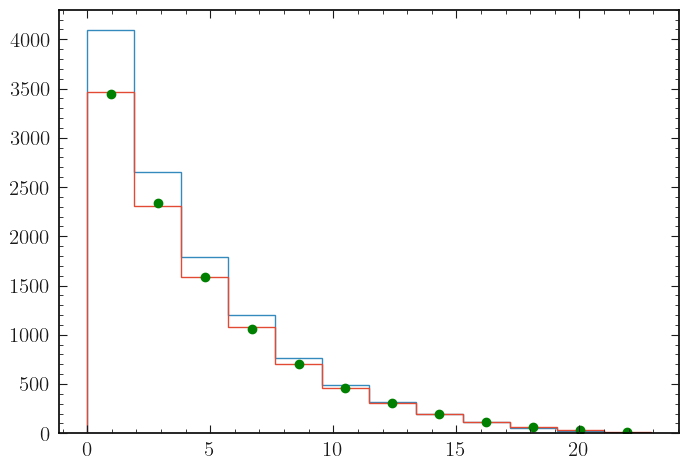

In [21]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit[:,0]), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')

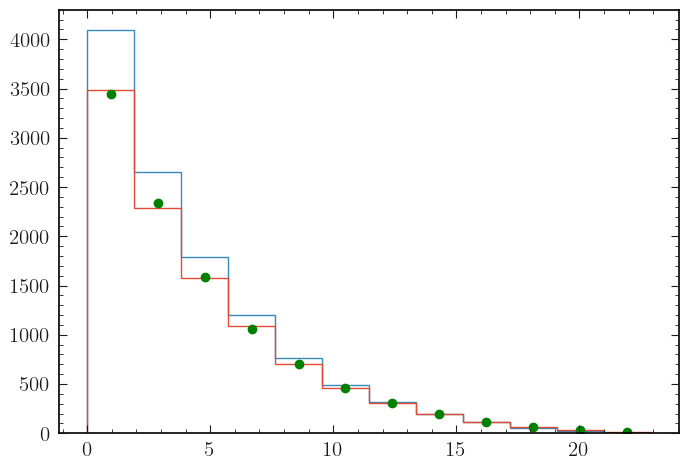

In [24]:
init = model.config.suggested_init()
init[model.config.par_map['cvl']['slice']] = [5.0]
init[model.config.par_map['cvr']['slice']] = [0.5]
init[model.config.par_map['csl']['slice']] = [0.5]
init[model.config.par_map['csr']['slice']] = [0.5]
init[model.config.par_map['ctl']['slice']] = [0.5]

plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(init), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')

In [25]:
model.expected_actualdata(init)

array([3482.34978885, 2288.83313238, 1577.84796773, 1084.17960192,
        703.48777375,  460.99997914,  309.75438093,  193.25101681,
        114.10468753,   64.06344446,   32.26637542,    9.41434756])